In [1]:
#!wget -O CVC-ClinicDB.rar https://ucc043e6e61110bb7ef247d710ff.dl.dropboxusercontent.com/cd/0/get/BBoZml6kBuberUIzpL6DtXKLHcQEqRr9LiVs-x3NhCeKhgGJ0U3GDQKLT84icw16ogvgt02JtIgkGJ2kyyKAN_whqS9qcVssSJBsc-OftKVUEQ/file?_download_id=671075465462148114642916227734783104483884681777600435071875955&_notify_domain=www.dropbox.com&dl=1

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
%%capture
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!pip install pytorch-lightning
!pip install thop
!pip install -U albumentations
!pip install torchgeometry

In [8]:
!unrar -s x '/content/drive/My Drive/CVC-ClinicDB.rar' CVC-ClinicDB > ext_log.txt
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB


# Imports

In [169]:
import math
import os
from os import listdir
from os.path import isfile, join
import matplotlib.image as mpimg
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
import pickle
from collections import defaultdict, OrderedDict
from tqdm.notebook import tqdm
import warnings
from thop import profile
from thop import clever_format
from IPython.display import clear_output


from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split


from albumentations.pytorch import ToTensor
import albumentations as A


import skimage.transform
import cv2
from PIL import Image
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters



import torch
import torch.nn as nn
import torchvision
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.autograd import Function
from torchvision import models, utils
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torchgeometry as tgm

# Res2Net

In [10]:
model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b lib.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s'],
                                                 map_location=torch.device('cpu')))
    return model


def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-101_v1b_26w_4s lib.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s'],
                                                 map_location=torch.device('cpu')))
    return model


In [11]:
images = torch.rand(1, 3, 224, 224)
model = res2net50_v1b_26w_4s(pretrained=True)
model = model
print(model(images).size())

Downloading: "https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth" to /root/.cache/torch/hub/checkpoints/res2net50_v1b_26w_4s-3cf99910.pth



torch.Size([1, 1000])


# Dataset

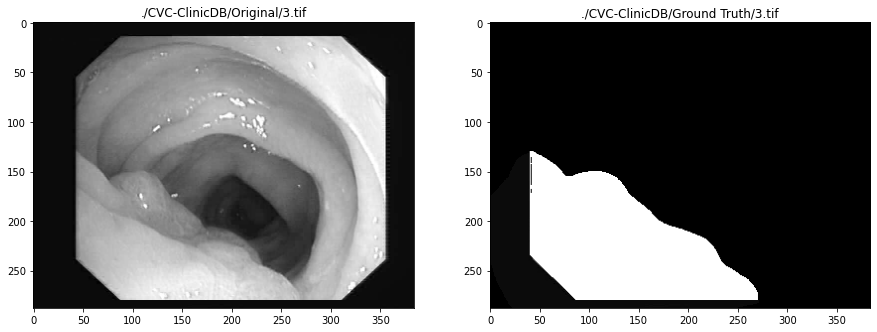

In [77]:
def CalParams(model, input_tensor):
    """
    Usage:
        Calculate Params and FLOPs via [THOP](https://github.com/Lyken17/pytorch-OpCounter)
    Necessarity:
        from thop import profile
        from thop import clever_format
    :param model:
    :param input_tensor:
    :return:
    """
    flops, params = profile(model, inputs=(input_tensor,))
    flops, params = clever_format([flops, params], "%.3f")
    print('[Statistics Information]\nFLOPs: {}\nParams: {}'.format(flops, params))


mypath = 'CVC-ClinicDB/Ground Truth/'
onlyfiles = [f.split('.')[0] for f in listdir(mypath) if isfile(join(mypath, f))]

#/content/CVC-ClinicDB/Original
def draw_plots(idx):
    fig, ax = plt.subplots(1, 2, figsize=(15,15))
    mask = cv2.imread(f'./CVC-ClinicDB/Ground Truth/{idx}.tif', cv2.IMREAD_GRAYSCALE)
    original = cv2.imread(f'./CVC-ClinicDB/Original/{idx}.tif')
    ax[0].imshow(original)
    ax[0].set_title(f'./CVC-ClinicDB/Original/{idx}.tif')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f'./CVC-ClinicDB/Ground Truth/{idx}.tif')
    plt.show()

draw_plots(onlyfiles[123])

In [159]:
image_size = (352, 352)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
split_size=0.1
BATCH_SIZE=16
root_path = 'CVC-ClinicDB/'
img_root = join(root_path, 'Original')
msk_root = join(root_path, 'Ground Truth')
image_names = [f for f in listdir(img_root) if isfile(join(img_root, f))]
masks_names = [f for f in listdir(msk_root) if isfile(join(msk_root, f))]
if set(image_names) != set(masks_names):
    raise ValueError('There are differences in masks and images')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class PolypDataset(Dataset):
    def __init__(self, root_path, image_names, transform):
      self.root_path = root_path
      self.img_root = join(root_path, 'Original')
      self.msk_root = join(root_path, 'Ground Truth')
      self.image_names = image_names
      self.transform = transform
      #self.img_transforms = img_transforms
      #self.mask_transforms = mask_transforms

    def __len__(self):
      return len(self.image_names)

    def __getitem__(self, item):
      image = cv2.imread(join(self.img_root, self.image_names[item]))#we use cv2 because PIL didnt load the image and we convert later to PIL image
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      #image = Image.fromarray(image) #Converting CV2 to PIL
      mask = cv2.imread(join(self.msk_root, self.image_names[item]), cv2.IMREAD_GRAYSCALE) #we use cv2 because PIL didnt load the image and we convert later to PIL image
      #_, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
      #mask = mask.astype(bool)
      #mask = Image.fromarray(mask) #we use cv2 because PIL didnt load the image and we convert later to PIL image
      #transformed_image = self.img_transforms(image)
      #transformed_mask = self.mask_transforms(mask)
      transformed = self.transform(image=image, mask=mask)
      return transformed['image'] , transformed['mask']


class CVCClinicDBDataModule(pl.LightningDataModule):
    def __init__(self, image_names, root_path, split_size=0.1,
                 batch_size=BATCH_SIZE, size_rates=[0.75, 1.25]):
        super().__init__()
        self.image_names = image_names
        self.split_size = split_size
        self.root_path = root_path
        self.batch_size = batch_size
        self.size_rates = size_rates
        
    def setup(self, stage):
        train_images, val_images  = train_test_split(self.image_names,
                                                     test_size=split_size,
                                                     random_state = 42)

        train_images, test_images = train_test_split(train_images,
                                                     test_size=split_size,
                                                     random_state = 42)
        # train dataset
        train_transform = A.Compose([
                      A.Resize(height=image_size[0], width=image_size[1], interpolation=cv2.INTER_LINEAR, p=1),
                      #A.RandomScale(scale_limit=self.size_rates, interpolation=cv2.INTER_LINEAR, p=0.5),
                      A.Flip(p=0.5),
                      A.Rotate(limit=(-20, 20), interpolation=cv2.INTER_LINEAR, p=0.5),
                      A.OneOf([A.IAAAdditiveGaussianNoise(),
                               A.GaussNoise()],
                          p=0.2),
                      A.OneOf([A.CLAHE(clip_limit=2),
                               A.IAASharpen(),
                               A.IAAEmboss(),
                               A.RandomBrightnessContrast()],
                          p=0.3),
                      A.HueSaturationValue(p=0.3),
                      A.Normalize(mean=mean, std=std, p=1.0),
                      ToTensor()],
                p = 1
        )
        self.train_dataset = PolypDataset(self.root_path,
                                          train_images,
                                          train_transform)
        # val dataset
        val_transform = A.Compose([
                A.Resize(height=image_size[0], width=image_size[1], interpolation=cv2.INTER_LINEAR, p=1),
                A.Normalize(mean=mean, std=std, p=1.0),
                ToTensor()
            ],
            p = 1
        )
        self.val_dataset = PolypDataset(self.root_path,
                                        val_images,
                                        val_transform)
        # test dataset
        test_transform = A.Compose([
                A.Resize(height=image_size[0], width=image_size[1], interpolation=cv2.INTER_LINEAR, p=1),
                A.Normalize(mean=mean, std=std, p=1.0),
                ToTensor()
            ],
            p = 1
        )
        self.test_dataset = PolypDataset(self.root_path,
                                         test_images,
                                         test_transform)


    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size,
                          pin_memory=True)

# Model PraNet

In [160]:
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation(nn.Module):
    # dense aggregation, it can be replaced by other aggregation previous, such as DSS, amulet, and so on.
    # used after MSF
    def __init__(self, channel):
        super(aggregation, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, 1, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x

In [161]:
class PraNet(nn.Module):
    # res2net based encoder decoder
    def __init__(self, channel=32):
        super(PraNet, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True).requires_grad_(False)
        # ---- Receptive Field Block like module ----
        self.rfb2_1 = RFB_modified(512, channel)
        self.rfb3_1 = RFB_modified(1024, channel)
        self.rfb4_1 = RFB_modified(2048, channel)
        # ---- Partial Decoder ----
        self.agg1 = aggregation(channel)
        # ---- reverse attention branch 4 ----
        self.ra4_conv1 = BasicConv2d(2048, 256, kernel_size=1)
        self.ra4_conv2 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv3 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv4 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv5 = BasicConv2d(256, 1, kernel_size=1)
        # ---- reverse attention branch 3 ----
        self.ra3_conv1 = BasicConv2d(1024, 64, kernel_size=1)
        self.ra3_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv4 = BasicConv2d(64, 1, kernel_size=3, padding=1)
        # ---- reverse attention branch 2 ----
        self.ra2_conv1 = BasicConv2d(512, 64, kernel_size=1)
        self.ra2_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv4 = BasicConv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)      # bs, 64, 88, 88
        # ---- low-level features ----
        x1 = self.resnet.layer1(x)      # bs, 256, 88, 88
        x2 = self.resnet.layer2(x1)     # bs, 512, 44, 44

        x3 = self.resnet.layer3(x2)     # bs, 1024, 22, 22
        x4 = self.resnet.layer4(x3)     # bs, 2048, 11, 11
        x2_rfb = self.rfb2_1(x2)        # channel -> 32
        x3_rfb = self.rfb3_1(x3)        # channel -> 32
        x4_rfb = self.rfb4_1(x4)        # channel -> 32

        ra5_feat = self.agg1(x4_rfb, x3_rfb, x2_rfb)
        lateral_map_5 = F.interpolate(ra5_feat, scale_factor=8, mode='bilinear')    # NOTES: Sup-1 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_4 ----
        crop_4 = F.interpolate(ra5_feat, scale_factor=0.25, mode='bilinear')
        x = -1*(torch.sigmoid(crop_4)) + 1
        x = x.expand(-1, 2048, -1, -1).mul(x4)
        x = self.ra4_conv1(x)
        x = F.relu(self.ra4_conv2(x))
        x = F.relu(self.ra4_conv3(x))
        x = F.relu(self.ra4_conv4(x))
        ra4_feat = self.ra4_conv5(x)
        x = ra4_feat + crop_4
        lateral_map_4 = F.interpolate(x, scale_factor=32, mode='bilinear')  # NOTES: Sup-2 (bs, 1, 11, 11) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_3 ----
        crop_3 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_3)) + 1
        x = x.expand(-1, 1024, -1, -1).mul(x3)
        x = self.ra3_conv1(x)
        x = F.relu(self.ra3_conv2(x))
        x = F.relu(self.ra3_conv3(x))
        ra3_feat = self.ra3_conv4(x)
        x = ra3_feat + crop_3
        lateral_map_3 = F.interpolate(x, scale_factor=16, mode='bilinear')  # NOTES: Sup-3 (bs, 1, 22, 22) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_2 ----
        crop_2 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_2)) + 1
        x = x.expand(-1, 512, -1, -1).mul(x2)
        x = self.ra2_conv1(x)
        x = F.relu(self.ra2_conv2(x))
        x = F.relu(self.ra2_conv3(x))
        ra2_feat = self.ra2_conv4(x)
        x = ra2_feat + crop_2
        lateral_map_2 = F.interpolate(x, scale_factor=8, mode='bilinear')   # NOTES: Sup-4 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        return lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2


In [162]:
ras = PraNet()
input_tensor = torch.randn(1, 3, 352, 352)
out = ras(input_tensor)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [163]:
CalParams(ras, input_tensor)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Bottle2neck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.Res2Net'>. Treat it as zero Macs and zero Params.
[WARN] Canno

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [164]:
class LightningPraNet(pl.LightningModule):

    def __init__(self, trainsize=352, size_rates=[0.75, 1, 1.25], lr=1e-4,
                 decay_rate=0.1, decay_epoch=50):
        super(LightningPraNet, self).__init__()
        self.model_net = PraNet()
        self.trainsize = trainsize
        self.size_rates = size_rates
        self.learning_rate = lr
        self.decay_rate = 0.1
        self.decay_epoch = 30

    def forward(self, x): 
        out = self.model_net(x)
        return out

    def _structure_loss(self, pred, mask):
        weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
        wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
        wbce = (weit*wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

        pred = torch.sigmoid(pred)
        inter = ((pred * mask)*weit).sum(dim=(2, 3))
        union = ((pred + mask)*weit).sum(dim=(2, 3))
        wiou = 1 - (inter + 1)/(union - inter+1)
        return (wbce + wiou).mean()

    def get_loss(self, pred, gts):
        lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2 = pred
        loss5 = self._structure_loss(lateral_map_5, gts)
        loss4 = self._structure_loss(lateral_map_4, gts)
        loss3 = self._structure_loss(lateral_map_3, gts)
        loss2 = self._structure_loss(lateral_map_2, gts)
        return loss2, loss3, loss4, loss5

    def training_step(self, train_batch, batch_idx):

        images, gts = train_batch
        #for rate in size_rates:
        #  trainsize = int(round(self.trainsize*rate/32)*32)
          #if rate != 1:
          #    images = F.upsample(images, size=(trainsize, trainsize),
          #                          mode='bilinear', align_corners=True)
          #    gts = F.upsample(gts, size=(trainsize, trainsize),
          #                       mode='bilinear', align_corners=True)

        #loss = tensor(0, device=self.device, requires_grad=True)
        pred = self.forward(images)
        loss2, loss3, loss4, loss5 = self.get_loss(pred, gts)
        loss = loss2 + loss3 + loss4 + loss5
        logs = {'train_loss_2': loss2,
                'train_loss_3': loss3,
                'train_loss_4': loss4,
                'train_loss_5': loss5,
                'loss': loss}
        self.log_dict(logs)
        return logs

    def validation_step(self, val_batch, batch_idx):
        images, gts = val_batch
        pred = self.forward(images)
        loss2, loss3, loss4, loss5 = self.get_loss(pred, gts)
        loss = loss2 + loss3 + loss4 + loss5
        logs = {'val_loss_2': loss2,
                'val_loss_3': loss3,
                'val_loss_4': loss4,
                'val_loss_5': loss5,
                'val_loss': loss}

        tgm.losses.dice_loss(input, target)
        
        self.log_dict(logs)
        return logs

    def validation_epoch_end(self, outputs):
        # called at the end of the validation epoch
        # outputs is an array with what you returned in validation_step for each batch
        # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        for i in range(2, 6):
            tensorboard_logs[f'val_loss_{i}'] = torch.stack([x[f'val_loss_{i}'] for x in outputs]).mean()
        self.log_dict(tensorboard_logs)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model_net.parameters(), lr=self.learning_rate)
        lr_lambda = lambda: self.decay_rate ** (self.current_epoch // self.decay_epoch)
        sched = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda, last_epoch=-1)
        sched_dict = {'scheduler': sched,
                      'interval': 'epoch',
                      'frequency': 1}
        result = {'optimizer': optimizer,
                  'scheduler': sched_dict}
        return result


In [170]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filepath='models/CVC-ClinicDB-{epoch:02d}-{val_loss:.2f}',
    save_top_k=-1,
    mode='min',
    period=20)

BATCH_SIZE = 256
data_module = CVCClinicDBDataModule(image_names, root_path, batch_size=BATCH_SIZE)
trainer = pl.Trainer(gpus=1, gradient_clip_val=0.5, max_epochs=300, checkpoint_callback=checkpoint_callback)
pra_net = LightningPraNet()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(pra_net, data_module)


  | Name      | Type   | Params
-------------------------------------
0 | model_net | PraNet | 32 M  


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecate

In [ ]:
trainer.test(ckpt_path=None)
#trainer.test(ckpt_path='/path/to/my_checkpoint.ckpt')
trainer.test(model)